In [1]:
import tensorflow as tf
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import warnings
import tqdm
warnings.filterwarnings('ignore')

C:\Users\PLCRCRD19\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading model

In [2]:
# Load graph data
loader = tf.train.import_meta_graph('saved_model/classifier_small.ckpt.meta')
sess = tf.Session()
loader.restore(sess,'saved_model/classifier_small.ckpt')
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from saved_model/classifier_small.ckpt


In [3]:
# Find relevant ops
assert len([op.name for op in graph.get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in graph.get_operations() if 'cnn_' in op.name]) == 0
print([op.name for op in graph.get_operations() if 'output' in op.name or 'features' in op.name])

['features', 'output']


In [4]:
# Grab them
x = graph.get_tensor_by_name('features:0')
y = graph.get_tensor_by_name('output:0')

# Testing model accuracy (just in case)

In [5]:
test_image = skimage.transform.resize(plt.imread('train/dog.1.jpg'), (128,128,3))
res = sess.run(y, feed_dict={x: [test_image]})
answer = 'cat' if res[0][0]>res[0][1] else 'dog'
print(f'{res[0]} - {answer}')

[0.2689439  0.73105603] - dog


In [6]:
def calculate_accuracy():
    counter = 0
    for i in tqdm.trange(1000):
        animal = 'cat' if i%2==0 else 'dog'
        test_image = skimage.transform.resize(plt.imread(f'train/{animal}.{i}.jpg'), (128,128,3))
        res = sess.run(y, feed_dict={x: [test_image]})
        answer = 'cat' if res[0][0]>res[0][1] else 'dog'
        if answer == animal:
            counter+=1
    return counter
      
counter = calculate_accuracy()
print(f'{counter/10}% accuracy')

100%|██████████████████████████████████████| 1000/1000 [00:21<00:00, 45.60it/s]


85.1% accuracy


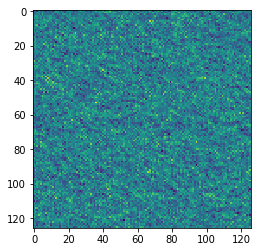

In [7]:
def T(layer):
    return graph.get_tensor_by_name(f'{layer}:0')

inp = x

img = np.random.uniform(size=(1,128,128,3)) + 100.0
res = sess.run(T('cnn/classificator/convolution/conv2d/Conv2D'), feed_dict={inp: img})
# res.T.shape
res = res/np.max(res)
plt.imshow(res[0,:,:,3])

# Dreaming!

#### List available conv layers

In [8]:
print([op.name for op in graph.get_operations() if 'Conv2D' in op.name and 'training' not in op.name])
# print([op.name for op in graph.get_operations() if 'output' in op.name and 'training' not in op.name])

['cnn/classificator/convolution/conv2d/Conv2D', 'cnn/classificator/convolution/conv2d_1/Conv2D', 'cnn/classificator/convolution/conv2d_2/Conv2D', 'cnn/classificator/convolution/conv2d_3/Conv2D']


### Dreaming algorithm: 
We pick a layer + feature and 'train' picture via gradient so that chosen layer gets max activation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


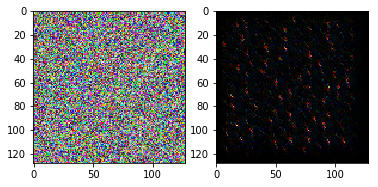

In [13]:
layer = 'cnn/classificator/convolution/conv2d_2/Conv2D'
feature = 8

# np.random.seed(0)
img_noise = np.random.random(size=(1,128,128,3))

def showarray(a, fmt='jpeg'):
    a = a/np.max(a)
    plt.imshow(a[0])

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, inp)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {inp:img})
        
        g /= g.std()+1e-8         
        img += g*step
    showarray(img)
        
    return img

op = T(layer)
plt.subplot(121)
plt.imshow(img_noise[0])
plt.subplot(122)
img = render_naive(op[:,:,:,feature])

In [14]:
def dream_image(img0, t_obj, feature, iter_n=20, step=1.0, bw=False, random=False):
    t_obj = t_obj[:,:,:,feature]
    entry_point = x if bw else inp
    if random and bw:
        img0 = np.random.random(size=(1,128,128,3))
    elif random:
        img0 = np.random.random(size=(1,128,128,3))
    
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, entry_point)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {entry_point:img})
        
        g /= g.std()+1e-8         
        img += g*step
        
    if bw:
        img = img[0,:,:,0]
    else:
        img = img[0]
        
    return img/np.max(img)

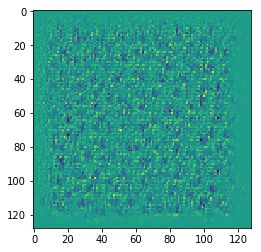

In [18]:
img = dream_image(None, T('cnn/classificator/convolution/conv2d_2/Conv2D'), 20, random=True, bw=True)
plt.imshow(img)

### Dreaming over cat picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


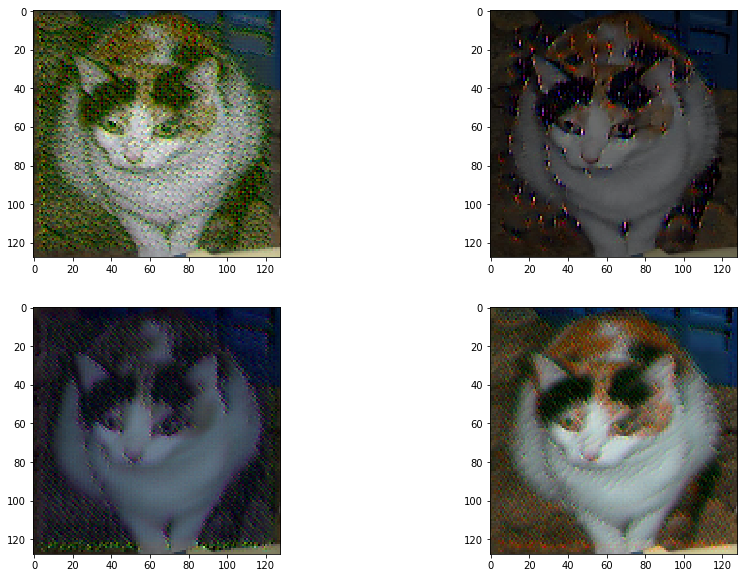

In [19]:
img = plt.imread(f'train/cat.111.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 11, step=0.01));
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 30, step=0.01));
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 20, step=0.02));
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 15, step=0.01));

### Dreaming over dog picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


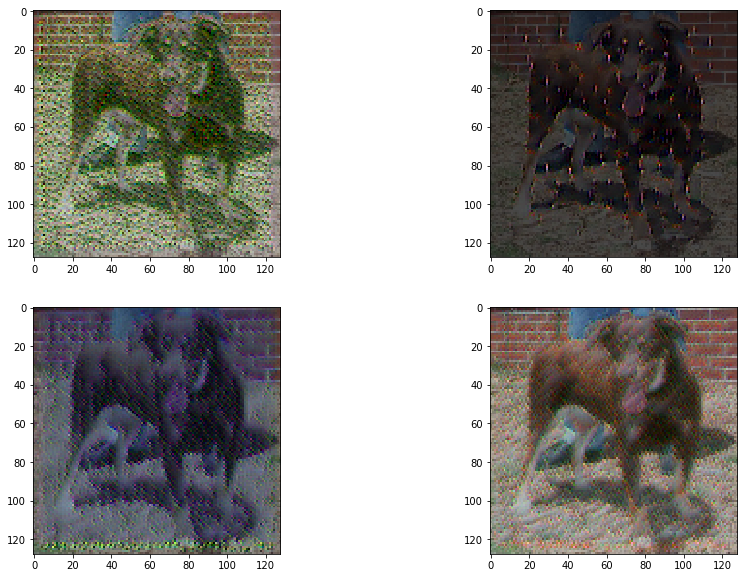

In [20]:
img = plt.imread(f'train/dog.323.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 11, step=0.01));
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 30, step=0.01));
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 20, step=0.02));
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 15, step=0.01));

### Dreaming over random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


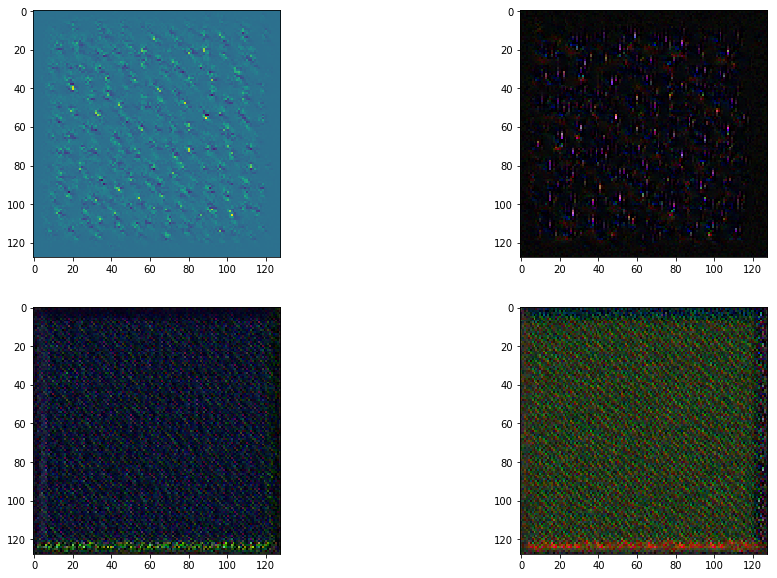

In [23]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 11, step=1, random=True, bw=True))
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 30, step=0.1, random=True))
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 20, step=0.1, random=True))
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 15, step=0.1, random=True))

### Dream over dog picture until it is recognized as a cat pic

Original asessment: 72% dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final asessment: 26% dog


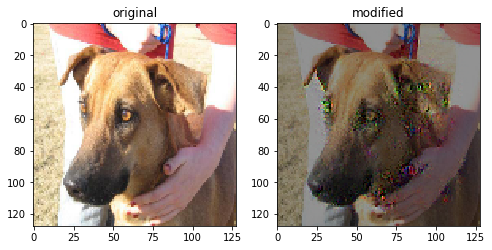

In [49]:
img = plt.imread(f'train/dog.123.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

op = T('output')

assess = sess.run(y, {inp:[img]})[0,1]*100
print(f'Original asessment: {int(assess)}% dog')

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img)
plt.title('original')
plt.subplot(122)
purified = render_naive(op[:,0], img0=[img], iter_n=20, step=0.05);
plt.title('modified')

assess = sess.run(y, {inp:purified})[0,1]*100
print(f'Final asessment: {int(assess)}% dog')

### Dream over random sample until it is recognized as a cat pic

Original asessment: 27% cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final asessment: 73% cat


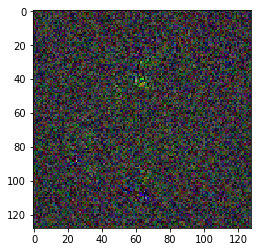

In [26]:
entry_point = x

img = np.random.uniform(size=(1,128,128,3))

assess = sess.run(y, {inp:img})[0,0]*100
print(f'Original asessment: {int(assess)}% cat')

purified = render_naive(op[:,0], img0=img, iter_n=20, step=0.1);

assess = sess.run(y, {inp:purified})[0,0]*100
print(f'Final asessment: {int(assess)}% cat')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


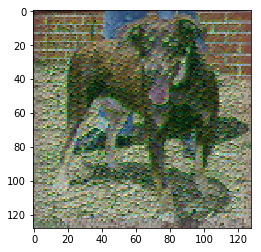

In [42]:
img = plt.imread(f'train/dog.323.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 23, step=0.01));